In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#!unzip yawn_eye.zip

In [ ]:
cd yawn_eye

/content/drive/MyDrive/yawn_eye


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="training",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 2221 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="validation",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 246 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="test",
    labels="inferred",
    batch_size=32,
    image_size=(256,256),
    validation_split=None,
)

Found 433 files belonging to 4 classes.


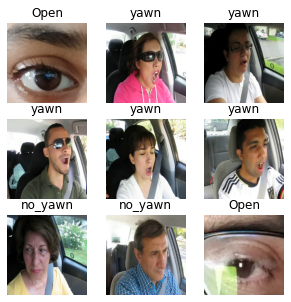

In [ ]:
class_names=train_ds.class_names
plt.figure(figsize=(5, 5))
for images ,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
aututune = tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=aututune)
val_ds=val_ds.cache().prefetch(buffer_size=aututune)
test_ds=test_ds.cache().prefetch(buffer_size=aututune)

In [ ]:
data_augmentation= tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, -0.1)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.3))
    ]
)

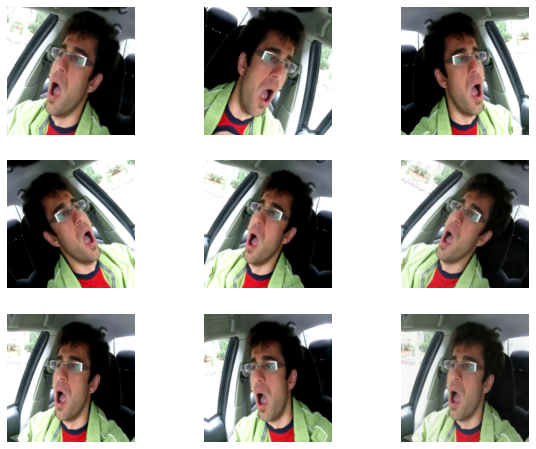

In [ ]:
image , label= next(iter(train_ds))
plt.figure(figsize=(10,8))
first_image=image[13]
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  augmented_image=data_augmentation(first_image)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis('off')

In [ ]:
model_vgg=tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model_vgg.trainable=False

In [ ]:
inputs= tf.keras.Input(shape=(256,256,3))
x=data_augmentation(inputs)
x=model_vgg(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(32,activation='elu',kernel_regularizer='l1_l2', bias_regularizer='l1_l2')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(64,activation='elu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=tf.keras.layers.Dense(4,activation="softmax")(x)
new_model=tf.keras.Model(inputs,outputs)

In [ ]:
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                2112  

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
checkpoint =  tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/tmp/checkpoint', save_weights_only=True,
    monitor='val_accuracy', mode='max',save_best_only=True
)
history=new_model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[callback,checkpoint])

Epoch 1/50
70/70 [==============================] - 1728s 25s/step - loss: 6.5893 - accuracy: 0.7789 - val_loss: 3.4712 - val_accuracy: 0.8943
Epoch 2/50
70/70 [==============================] - 1654s 24s/step - loss: 2.0796 - accuracy: 0.8757 - val_loss: 1.1744 - val_accuracy: 0.9431
Epoch 3/50
70/70 [==============================] - 1655s 24s/step - loss: 0.9272 - accuracy: 0.9041 - val_loss: 0.7334 - val_accuracy: 0.9634
Epoch 4/50
70/70 [==============================] - 1653s 24s/step - loss: 0.6410 - accuracy: 0.9163 - val_loss: 0.6583 - val_accuracy: 0.9187
Epoch 5/50
70/70 [==============================] - 1653s 24s/step - loss: 0.5726 - accuracy: 0.9212 - val_loss: 0.5690 - val_accuracy: 0.9390
Epoch 6/50
70/70 [==============================] - 1656s 24s/step - loss: 0.5479 - accuracy: 0.9298 - val_loss: 0.5831 - val_accuracy: 0.9512
Epoch 7/50
70/70 [==============================] - 1653s 24s/step - loss: 0.5240 - accuracy: 0.9365 - val_loss: 0.5345 - val_accuracy: 0.9268

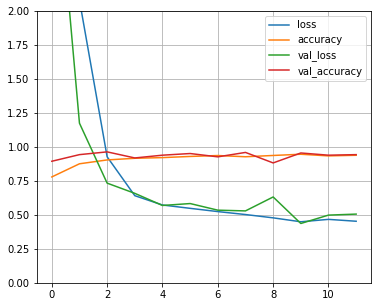

In [ ]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [ ]:
loss_t, acc_t= new_model.evaluate(test_ds)
print(acc_t)

14/14 [==============================] - 296s 21s/step - loss: 0.6125 - accuracy: 0.8938
0.8937644362449646


In [ ]:
y_pred=new_model.predict(test_ds)

14/14 [==============================] - 387s 21s/step


In [ ]:
y_pred

array([[6.9781548e-01, 3.0144793e-01, 1.0790272e-04, 6.2872242e-04],
       [1.0116953e-02, 9.8975074e-01, 8.2305687e-06, 1.2394830e-04],
       [4.1633206e-03, 1.1781279e-03, 9.0433604e-01, 9.0322495e-02],
       ...,
       [1.3759299e-04, 9.9985409e-01, 3.1470802e-07, 8.0034133e-06],
       [2.5114962e-01, 7.4818975e-01, 3.4274210e-04, 3.1789555e-04],
       [4.3256916e-03, 3.8060022e-03, 1.2745939e-01, 8.6440891e-01]],
      dtype=float32)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)
y_pred

array([0, 1, 2, 3, 2, 2, 3, 2, 2, 0, 1, 2, 3, 0, 2, 0, 2, 2, 2, 2, 3, 2,
       1, 1, 1, 2, 2, 3, 3, 3, 2, 0, 2, 1, 2, 3, 0, 1, 1, 1, 0, 1, 2, 0,
       2, 1, 3, 1, 0, 1, 2, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 1, 1, 0, 1, 2,
       1, 2, 3, 1, 1, 1, 2, 0, 2, 3, 2, 1, 0, 0, 1, 2, 1, 2, 0, 1, 2, 1,
       3, 2, 1, 1, 0, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 0, 3, 3, 2, 0,
       2, 3, 2, 1, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1, 0, 3, 2, 2, 1, 1,
       1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 3, 3, 2, 3, 2, 3, 2,
       0, 2, 2, 1, 3, 1, 3, 0, 3, 0, 0, 2, 2, 3, 1, 2, 2, 1, 1, 1, 0, 3,
       0, 1, 3, 2, 1, 1, 3, 0, 1, 2, 2, 1, 3, 2, 1, 0, 2, 1, 0, 0, 2, 1,
       0, 0, 2, 2, 0, 0, 3, 1, 1, 1, 0, 1, 2, 2, 3, 2, 0, 2, 2, 0, 2, 1,
       0, 2, 2, 1, 1, 1, 1, 0, 2, 1, 1, 3, 2, 1, 2, 2, 3, 0, 1, 0, 2, 1,
       0, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 3, 3, 0, 0, 2, 2, 0, 1, 2, 1, 3,
       0, 1, 2, 0, 3, 0, 2, 0, 2, 1, 1, 2, 3, 2, 0, 2, 1, 0, 0, 1, 1, 2,
       1, 0, 2, 3, 1, 0, 1, 2, 1, 2, 0, 0, 3, 2, 2,

In [ ]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test

array([0, 1, 2, 3, 2, 2, 3, 2, 2, 0, 1, 3, 3, 0, 2, 0, 2, 3, 2, 2, 3, 3,
       1, 0, 1, 2, 2, 3, 3, 3, 2, 0, 2, 1, 2, 3, 0, 1, 1, 1, 0, 1, 2, 0,
       2, 1, 3, 1, 0, 1, 2, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 1, 0, 1, 2,
       1, 2, 3, 1, 1, 1, 2, 0, 2, 3, 2, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1,
       3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 2, 3, 1, 1, 0, 0, 0, 3, 3, 2, 0,
       2, 3, 2, 1, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 1, 0, 3, 2, 3, 1, 1,
       1, 0, 2, 2, 2, 1, 2, 2, 3, 0, 2, 3, 1, 2, 3, 3, 3, 2, 3, 2, 3, 2,
       0, 3, 3, 1, 3, 1, 3, 0, 3, 0, 0, 2, 2, 3, 1, 2, 3, 1, 1, 1, 0, 3,
       0, 1, 3, 2, 1, 1, 3, 0, 1, 2, 2, 1, 3, 2, 0, 0, 2, 0, 0, 0, 3, 1,
       0, 0, 2, 2, 0, 0, 3, 1, 1, 1, 0, 0, 2, 3, 3, 3, 0, 3, 2, 0, 3, 0,
       0, 2, 3, 1, 1, 1, 1, 0, 3, 1, 0, 3, 2, 1, 2, 2, 3, 0, 1, 0, 2, 1,
       0, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 3, 3, 0, 0, 3, 2, 0, 1, 3, 1, 3,
       0, 1, 2, 0, 3, 0, 3, 0, 2, 1, 1, 2, 3, 3, 0, 2, 1, 0, 0, 1, 1, 2,
       0, 0, 2, 3, 1, 0, 1, 2, 1, 2, 0, 0, 3, 2, 3,

In [ ]:
test_ds.class_names

['Closed', 'Open', 'no_yawn', 'yawn']

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=test_ds.class_names)
print(report) 

              precision    recall  f1-score   support

      Closed       1.00      0.89      0.94       109
        Open       0.90      1.00      0.95       109
     no_yawn       0.76      1.00      0.87       109
        yawn       1.00      0.68      0.81       106

    accuracy                           0.89       433
   macro avg       0.92      0.89      0.89       433
weighted avg       0.92      0.89      0.89       433

